In [1]:
import pandas as pd
import utils
import plotly.express as px
import scipy.stats as sps
import numpy as np

color_discrete_map_gp = {'ORF': 'rgb(0,158,115)',
                    'CRISPR': 'rgb(213,94,0)'}

color_discrete_map_gene_target = {'Same': 'rgb(86,180,233)',
                              'Different': 'rgb(230,159,0)'}

### Visualizing the directionality of CRIPSR and ORF matching to compounds
In this notebook, we calculate the cosine similarities for CRISPR-compound and ORF-compound targeting the same genes, for the CellProfiler features.

All compound, ORF and CRISPR plates from the `2020_11_04_CPJUMP1` batch are read, except for those with cell seeding density other than 1000 (100%) and compound plates with antibiotics (Puromycin/Blasticidin) added. Additional annotations for the compounds are also read.

Normalized, feature selected compound profiles for replicate plates at the same time point, using the same cell type are merged into a single data frame. Negative control and empty wells are removed before computing the median consensus profiles for all compounds and adding additional target annotations. Similarly, consensus ORF and CRISPR profiles are also computed at the two time point and cell types.

Cosine similarity between the consensus chemical and genetic perturbation profiles are computed for all combinations of time point, within each cell type.

In [2]:
matching_df = pd.DataFrame()
matching_statistic_df = pd.DataFrame()
matching_1_statistic_df = pd.DataFrame()
orf_crispr_matching_df = pd.DataFrame()
orf_crispr_matching_statistic_df = pd.DataFrame()
feature_to_group_by = "Metadata_broad_sample"
batch = "2020_11_04_CPJUMP1"

experiment_df = (
    pd.read_csv('output/experiment-metadata.tsv', sep='\t')
    .query('Batch==@batch')
    .query('Density=="100"')
    .query('Antibiotics=="absent"')
)

experiment_df.drop(experiment_df[(experiment_df.Perturbation == "compound") & (experiment_df.Cell_line == "Cas9")].index, inplace=True)

target1_metadata = (
    pd.read_csv('input/JUMP-Target-1_compound_metadata_additional_annotations.tsv', sep='\t', usecols=['broad_sample', 'target_list'])
    .rename(columns={'broad_sample':'Metadata_broad_sample', 'target_list':'Metadata_target_list'})
)

In [3]:
for cell in experiment_df.Cell_type.unique():
    cell_df = experiment_df.query('Cell_type==@cell')
    modality_1_perturbation = "compound"
    modality_1_experiments_df = cell_df.query('Perturbation==@modality_1_perturbation')
    for modality_1_timepoint in modality_1_experiments_df.Time.unique():
        modality_1_timepoint_df = modality_1_experiments_df.query('Time==@modality_1_timepoint')
        modality_1_df = pd.DataFrame()
        for plate in modality_1_timepoint_df.Assay_Plate_Barcode.unique():
            # Read all the plates
            data_df = (
                utils.load_data(batch, plate, "normalized_feature_select_negcon_batch.csv.gz")
                .assign(Metadata_modality=modality_1_perturbation)
            )
            modality_1_df = utils.concat_profiles(modality_1_df, data_df)

        # Remove DMSO and empty wells
        modality_1_df = utils.remove_negcon_empty_wells(modality_1_df)

        # Create consensus profiles
        modality_1_consensus_df = utils.consensus(modality_1_df, feature_to_group_by)

        # Adding additional gene annotation metadata
        modality_1_consensus_df = (
            modality_1_consensus_df.merge(target1_metadata, on='Metadata_broad_sample', how='left')
        )

        # Expand compound profiles and add new matching_target column
        modality_1_consensus_expanded_df = (
            modality_1_consensus_df.assign(Metadata_matching_target= lambda x: x.Metadata_target_list.str.split('|'))
            .explode('Metadata_matching_target')
            .reset_index(drop=True)
        )

        all_modality_2_experiments_df = cell_df.query('Perturbation!=@modality_1_perturbation')
        for modality_2_perturbation in all_modality_2_experiments_df.Perturbation.unique():
            modality_2_experiments_df = all_modality_2_experiments_df.query('Perturbation==@modality_2_perturbation')
            for modality_2_timepoint in modality_2_experiments_df.Time.unique():
                modality_2_timepoint_df = modality_2_experiments_df.query('Time==@modality_2_timepoint')

                modality_2_df = pd.DataFrame()
                for plate in modality_2_timepoint_df.Assay_Plate_Barcode.unique():
                    data_df = (
                        utils.load_data(batch, plate, "normalized_feature_select_negcon_batch.csv.gz")
                        .assign(Metadata_modality=modality_2_perturbation)
                        .assign(Metadata_matching_target=lambda x: x.Metadata_gene)
                    )
                    modality_2_df = utils.concat_profiles(modality_2_df, data_df)
                
                # Remove negcon and empty wells
                modality_2_df = utils.remove_negcon_empty_wells(modality_2_df)

                # Create consensus profiles (Replicates and sister guides are collapsed)
                modality_2_consensus_df = utils.consensus(modality_2_df, "Metadata_matching_target")

                # Filter out genes that are not perturbed by ORFs or CRISPRs
                perturbed_genes = list(set(modality_2_consensus_df.Metadata_matching_target))
                modality_1_consensus_expanded_filtered_df = modality_1_consensus_expanded_df.query('Metadata_matching_target==@perturbed_genes').reset_index(drop=True)

                # Calculate gene-compound matching mAP
                description = f'{modality_1_perturbation}_{cell}_{utils.time_point(modality_1_perturbation, modality_1_timepoint)}-{modality_2_perturbation}_{cell}_{utils.time_point(modality_2_perturbation, modality_2_timepoint)}'
                print(f'Computing {description} matching')
                precision = utils.PrecisionScores(modality_1_consensus_expanded_filtered_df, modality_2_consensus_df, "Metadata_matching_target", "matching", "Metadata_broad_sample")

                corr_unstacked = (
                    precision.corr
                    .unstack()
                    .reset_index()
                    .rename(columns={0: 'cosine_sim'})
                    .merge(precision.map2[["Metadata_sample_id", "Metadata_matching_target"]], left_on='level_0', right_on='Metadata_sample_id', how='left')
                    .drop(['Metadata_sample_id'], axis=1)
                    .merge(precision.map1[["Metadata_sample_id","Metadata_broad_sample"]], left_on='level_1', right_on='Metadata_sample_id', how='left')
                    .drop(['Metadata_sample_id'], axis=1)
                )

                truth_unstacked = (
                    precision.truth_matrix
                    .unstack()
                    .reset_index()
                    .rename(columns={0: 'same_target'})
                )

                corr_truth = (
                    corr_unstacked.merge(truth_unstacked, on=['level_0', 'level_1'], how='inner')
                    .assign(Modality1=f'{modality_1_perturbation}')
                    .assign(Genetic_Perturbation=f'{modality_2_perturbation}')
                    .assign(Cell=cell)
                    .assign(n_targets=1)
                    .assign(Modality_1_timepoint=utils.time_point(modality_1_perturbation, modality_1_timepoint))
                    .assign(Modality_2_timepoint=utils.time_point(modality_2_perturbation, modality_2_timepoint))
                )

                matching_df = (
                    utils.concat_profiles(matching_df, corr_truth)
                )

Computing compound_A549_short-crispr_A549_long matching
Computing compound_A549_short-crispr_A549_short matching
Computing compound_A549_short-orf_A549_long matching
Computing compound_A549_short-orf_A549_short matching
Computing compound_A549_long-crispr_A549_long matching
Computing compound_A549_long-crispr_A549_short matching
Computing compound_A549_long-orf_A549_long matching
Computing compound_A549_long-orf_A549_short matching
Computing compound_U2OS_short-crispr_U2OS_long matching
Computing compound_U2OS_short-crispr_U2OS_short matching
Computing compound_U2OS_short-orf_U2OS_short matching
Computing compound_U2OS_short-orf_U2OS_long matching
Computing compound_U2OS_long-crispr_U2OS_long matching
Computing compound_U2OS_long-crispr_U2OS_short matching
Computing compound_U2OS_long-orf_U2OS_short matching
Computing compound_U2OS_long-orf_U2OS_long matching


In [4]:
matching_df = matching_df.replace({'compound':'Compound','crispr':'CRISPR','orf':'ORF'})

In [5]:
cols = ['Cell','Genetic_Perturbation','Modality_1_timepoint','Modality_2_timepoint','cosine_sim']

(
    matching_df.query('same_target==True')
    .sort_values(by=cols)
)[cols + ['Metadata_broad_sample', 'Metadata_matching_target']].to_csv('output/compound_genetic_perturbation_cosine_similarity.csv', index=False)

Box plots are plotted for CRISPR and ORF z-scored (against the null) cosine similarities to compound in the two cell types, separately. The different time points are collapsed.

In [6]:
matching_df.rename(columns={'same_target': 'Gene_Target'}, inplace=True)
matching_df.replace(True, 'Same', inplace=True)
matching_df.replace(False, 'Different', inplace=True)

In [7]:
matching_df_z_score = pd.DataFrame()

for cell in matching_df.Cell.unique():
    for genetic_perturbation in matching_df.Genetic_Perturbation.unique():
        cell_gp_df = matching_df.query('Cell==@cell and Genetic_Perturbation==@genetic_perturbation').reset_index(drop=True)
        signal_df = cell_gp_df.query('Gene_Target=="Same"').reset_index(drop=True)
        null_df = cell_gp_df.query('Gene_Target=="Different"').reset_index(drop=True)
        signal_df['cosine_sim_zscore'] = (signal_df.cosine_sim - null_df.cosine_sim.mean())/null_df.cosine_sim.std()

        matching_df_z_score = pd.concat([matching_df_z_score, signal_df], ignore_index=True)


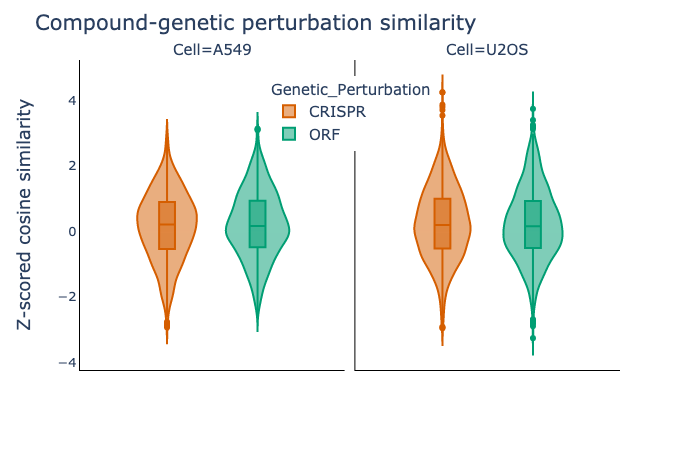

In [8]:
fig = px.violin(
    matching_df_z_score,
    y = 'cosine_sim_zscore',
    color = 'Genetic_Perturbation',
    facet_col = 'Cell',
    color_discrete_map=color_discrete_map_gp,
    box=True
    )
fig.update_layout(title='Compound-genetic perturbation similarity',
    xaxis1=dict(title='', linecolor = "#000000"),
    xaxis2=dict(title='', linecolor = "#000000"),
    yaxis1=dict(title='Z-scored cosine similarity', linecolor = "#000000", tickfont=dict(size=13)),
    yaxis2=dict(linecolor = "#000000"),
    font=dict(size=15),
    paper_bgcolor='rgba(0,0,0,0)',
    plot_bgcolor='rgba(0,0,0,0)',
    legend=dict(x=0.35, y=0.95, bgcolor="white")
)
fig.show("png")
fig.write_image('figures/5.cosine_similarities.png', width=640, height=480, scale=2)

t-test is performed to ascertain if the signal distribution cosine similarities (compound and genetic perturbations targeting the same gene) are different from the null distribution cosine similarities (compound and genetic perturbations targeting different genes).

In [9]:
for cell_type in matching_df_z_score.Cell.unique():
    cell_df = matching_df_z_score.query('Cell==@cell_type')

    crispr_df = cell_df.query('Genetic_Perturbation=="CRISPR"')
    orf_df = cell_df.query('Genetic_Perturbation=="ORF"')

    ttest_2sample = sps.ttest_ind(crispr_df.cosine_sim_zscore.values, orf_df.cosine_sim_zscore.values)

    matching_statistic_df = matching_statistic_df.append({'Cell': f'{cell_type}', 
                                                          'Distributions compared': 'Compound-CRISPR vs. Compound-ORF',
                                                          'statistic': ttest_2sample.statistic,
                                                          'pvalue': f'{utils.convert_pvalue(ttest_2sample.pvalue)}'}, ignore_index=True)

In [10]:
print(matching_statistic_df[['Cell', 'Distributions compared', 'statistic', 'pvalue']].to_markdown(index=False))

| Cell   | Distributions compared           |   statistic |   pvalue |
|:-------|:---------------------------------|------------:|---------:|
| A549   | Compound-CRISPR vs. Compound-ORF |   -1.3631   |     0.17 |
| U2OS   | Compound-CRISPR vs. Compound-ORF |    0.329589 |     0.74 |


Scatter plot between the mean cosine similarity of a compound and genetic perturbations targeting the same gene and the number of gene targets of the compound, is plotted.

In [11]:
matching_df_z_score_grouped = matching_df_z_score.groupby(['Cell','Modality1','Genetic_Perturbation','Metadata_broad_sample']).agg(
    {'cosine_sim_zscore' : lambda x: x.mean(),
    'n_targets': lambda y: y.sum()/4}).reset_index()


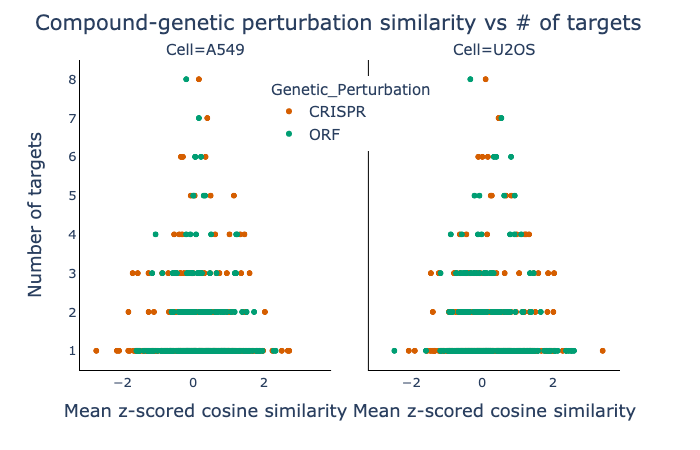

In [12]:
fig = px.scatter(
    matching_df_z_score_grouped,
    x='cosine_sim_zscore',
    y='n_targets',
    facet_col = 'Cell',
    facet_col_spacing=0.07,
    color='Genetic_Perturbation',
    color_discrete_map=color_discrete_map_gp,
)
fig.update_layout(title='Compound-genetic perturbation similarity vs # of targets',
    xaxis1=dict(title='Mean z-scored cosine similarity', linecolor = "#000000", tickfont=dict(size=13)),
    xaxis2=dict(title='Mean z-scored cosine similarity', linecolor = "#000000", tickfont=dict(size=13)),
    yaxis1=dict(title='Number of targets', linecolor = "#000000", tickfont=dict(size=13)),
    yaxis2=dict(linecolor = "#000000"),
    font=dict(size=15),
    paper_bgcolor='rgba(0,0,0,0)',
    plot_bgcolor='rgba(0,0,0,0)',
    legend=dict(x=0.35, y=0.95, bgcolor="white")
)
fig.for_each_annotation(lambda a: a.update(text=a.text.replace("Genetic_Perturbation=", "")))
fig.show("png")
fig.write_image('figures/5.cosine_similarities_ntargets.png', width=640, height=480, scale=2)

Plot compounds with only one annotated target

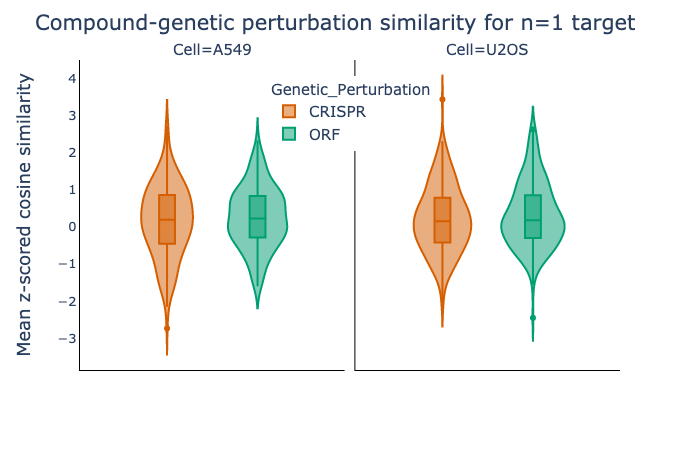

In [13]:
matching_df_z_score_grouped_n_1 = matching_df_z_score_grouped.query('n_targets==1')

fig = px.violin(
    matching_df_z_score_grouped_n_1,
    y = 'cosine_sim_zscore',
    color='Genetic_Perturbation',
    color_discrete_map=color_discrete_map_gp,
    facet_col = 'Cell',
    box=True
)
fig.update_layout(title='Compound-genetic perturbation similarity for n=1 target',
    xaxis1=dict(title='', linecolor="#000000", tickfont=dict(size=13)),
    xaxis2=dict(title='', linecolor="#000000", tickfont=dict(size=13)),
    yaxis1=dict(title='Mean z-scored cosine similarity', linecolor = "#000000", tickfont=dict(size=13)),
    yaxis2=dict(linecolor = "#000000"),
    font=dict(size=15),
    paper_bgcolor='rgba(0,0,0,0)',
    plot_bgcolor='rgba(0,0,0,0)',
    legend=dict(x=0.35, y=0.95, bgcolor="white")
)
fig.for_each_annotation(lambda a: a.update(text=a.text.replace("Genetic_Perturbation=", "")))
fig.show("png")
fig.write_image('figures/5.cosine_similarities_n1.png', width=640, height=480, scale=2)

In [14]:
for cell_type in matching_df_z_score_grouped_n_1.Cell.unique():
    crispr_df = matching_df_z_score_grouped_n_1.query('Cell==@cell_type').query('Genetic_Perturbation=="CRISPR"')
    orf_df = matching_df_z_score_grouped_n_1.query('Cell==@cell_type').query('Genetic_Perturbation=="ORF"')

    ttest_2sample = sps.ttest_ind(crispr_df.cosine_sim_zscore.values, orf_df.cosine_sim_zscore.values)

    matching_1_statistic_df = matching_1_statistic_df.append({'Cell': f'{cell_type}', 
                                                              'statistic': ttest_2sample.statistic,
                                                              'pvalue': f'{utils.convert_pvalue(ttest_2sample.pvalue)}'}, ignore_index=True)

In [15]:
print(matching_1_statistic_df[['Cell', 'statistic', 'pvalue']].to_markdown(index=False))

| Cell   |   statistic |   pvalue |
|:-------|------------:|---------:|
| A549   |    -1.10964 |     0.27 |
| U2OS   |    -1.34695 |     0.18 |


### Visualize the cosine similarity between ORF and CRISPR profiles
We calculate the cosine similarity between the following pairs of ORF and CRISPR profiles

- A549
    - ORF short time point - CRISPR short time point
    - ORF short time point vs. CRISPR long time point
    - ORF long time point vs. CRISPR short time point
    - ORF long time point vs. CRISPR long time point
- U2OS
    - ORF short time point vs. CRISPR short time point
    - ORF short time point vs. CRISPR long time point
    - ORF long time point vs. CRISPR short time point
    - ORF long time point vs. CRISPR long time point

Cosine similarity between median consensus ORF and CRISPR profiles are computed.

In [16]:
genetic_perturbation_experiment_df = experiment_df.query('Perturbation!="compound"')

for cell in genetic_perturbation_experiment_df.Cell_type.unique():
    cell_df = genetic_perturbation_experiment_df.query('Cell_type==@cell')
    orf_cell_df = cell_df.query('Perturbation=="orf"')
    for orf_timepoint in orf_cell_df.Time.unique():
        orf_timepoint_df = orf_cell_df.query('Time==@orf_timepoint')
        orf_df = pd.DataFrame()
        for plate in orf_timepoint_df.Assay_Plate_Barcode.unique():
            data_df = (
                utils.load_data(batch, plate, "normalized_feature_select_negcon_batch.csv.gz")
                .assign(Metadata_matching_target=lambda x: x.Metadata_gene)
            )
            orf_df = utils.concat_profiles(orf_df, data_df)
        
        # Remove DMSO and empty wells
        orf_df = utils.remove_negcon_empty_wells(orf_df)

        # Create consensus profiles (Replicates and sister guides are collapsed)
        orf_consensus_df = utils.consensus(orf_df, "Metadata_matching_target")

        crispr_cell_df = cell_df.query('Perturbation=="crispr"')
        for crispr_timepoint in crispr_cell_df.Time.unique():
            crispr_timepoint_df = crispr_cell_df.query('Time==@crispr_timepoint')
            crispr_df = pd.DataFrame()
            for plate in crispr_timepoint_df.Assay_Plate_Barcode.unique():
                data_df = (
                    utils.load_data(batch, plate, "normalized_feature_select_negcon_batch.csv.gz")
                    .assign(Metadata_matching_target=lambda x: x.Metadata_gene)
                )
                crispr_df = utils.concat_profiles(crispr_df, data_df)
        
            # Remove DMSO and empty wells
            crispr_df = utils.remove_negcon_empty_wells(crispr_df)

            # Create consensus profiles (Replicates and sister guides are collapsed)
            crispr_consensus_df = utils.consensus(crispr_df, "Metadata_matching_target")

            # Calculate gene-compound matching mAP
            description = f'ORF_{orf_timepoint}-CRISPR_{crispr_timepoint}'
            print(f'Computing {description} matching in {cell}')
            precision = utils.PrecisionScores(orf_consensus_df, crispr_consensus_df, "Metadata_matching_target", "matching", "Metadata_broad_sample")

            corr_unstacked = (
                        precision.corr
                        .unstack()
                        .reset_index()
                        .rename(columns={0: 'cosine_sim'})
                        .merge(precision.map2[["Metadata_sample_id", "Metadata_matching_target"]], left_on='level_0', right_on='Metadata_sample_id', how='left')
                        .drop(['Metadata_sample_id'], axis=1)
                        .merge(precision.map1[["Metadata_sample_id","Metadata_broad_sample"]], left_on='level_1', right_on='Metadata_sample_id', how='left')
                        .drop(['Metadata_sample_id'], axis=1)
                    )

            truth_unstacked = (
                precision.truth_matrix
                .unstack()
                .reset_index()
                .rename(columns={0: 'same_target'})
            )

            corr_truth = (
                corr_unstacked.merge(truth_unstacked, on=['level_0', 'level_1'], how='inner')
                .assign(Modality1="ORF")
                .assign(ORF_time=orf_timepoint)
                .assign(Modality2="CRISPR")
                .assign(CRISPR_time=crispr_timepoint)
                .assign(Cell=cell)
            )

            orf_crispr_matching_df = utils.concat_profiles(orf_crispr_matching_df, corr_truth)

Computing ORF_48-CRISPR_144 matching in U2OS
Computing ORF_48-CRISPR_96 matching in U2OS
Computing ORF_96-CRISPR_144 matching in U2OS
Computing ORF_96-CRISPR_96 matching in U2OS
Computing ORF_96-CRISPR_144 matching in A549
Computing ORF_96-CRISPR_96 matching in A549
Computing ORF_48-CRISPR_144 matching in A549
Computing ORF_48-CRISPR_96 matching in A549


Boxplot of ORF-CRISPR cosine similarity is plotted for each cell type separately. The time points are collapsed.

In [17]:
orf_crispr_matching_df.rename(columns={'same_target': 'Gene_Target'}, inplace=True)
orf_crispr_matching_df.replace(True, 'Same', inplace=True)
orf_crispr_matching_df.replace(False, 'Different', inplace=True)

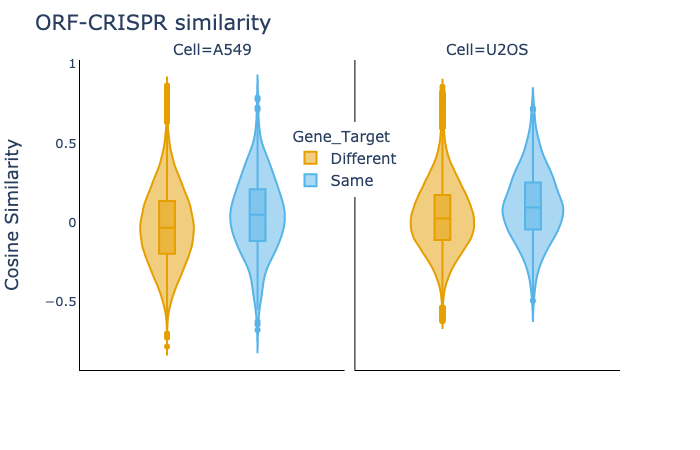

In [18]:
fig = px.violin(
    orf_crispr_matching_df,
    y = 'cosine_sim',
    color = 'Gene_Target',
    facet_col = 'Cell',
    category_orders={'Cell':['A549', 'U2OS']},
    color_discrete_map=color_discrete_map_gene_target,
    box=True
    )
fig.update_layout(title='ORF-CRISPR similarity',
    xaxis1=dict(linecolor = "#000000", tickfont=dict(size=13)),
    xaxis2=dict(linecolor = "#000000", tickfont=dict(size=13)),
    yaxis1=dict(title='Cosine Similarity', linecolor = "#000000", tickfont=dict(size=13)),
    yaxis2=dict(linecolor = "#000000"),
    font=dict(size=15),
    paper_bgcolor='rgba(0,0,0,0)',
    plot_bgcolor='rgba(0,0,0,0)',
    legend=dict(x=0.39, y=0.8, bgcolor="white")
)
fig.show("png")
fig.write_image('figures/5.orf_crispr_cosine_similarities.png', width=640, height=480, scale=2)

t-test is performed to ascertain whether the signal distribution (ORF and CRISPR targeting the same gene) is different from the null distribution (ORF and CRISPR targeting different genes).

In [19]:
for cell_type in orf_crispr_matching_df.Cell.unique():
    cell_df = orf_crispr_matching_df.query('Cell==@cell_type').query('Gene_Target=="Same"')
    cell_null_df = orf_crispr_matching_df.query('Cell==@cell_type').query('Gene_Target=="Different"')

    ttest_2sample = sps.ttest_ind(cell_df.cosine_sim.values, cell_null_df.cosine_sim.values)

    orf_crispr_matching_statistic_df = orf_crispr_matching_statistic_df.append({'Cell': f'{cell_type}', 
                                                                                'statistic': ttest_2sample.statistic,
                                                                                'pvalue': f'{utils.convert_pvalue(ttest_2sample.pvalue)}'}, ignore_index=True)


In [20]:
print(orf_crispr_matching_statistic_df[['Cell', 'statistic', 'pvalue']].to_markdown(index=False))

| Cell   |   statistic | pvalue   |
|:-------|------------:|:---------|
| U2OS   |     8.2333  | <0.05    |
| A549   |     7.55276 | <0.05    |
